# Animated Line Chart
This notebook demonstrates how to create an animated custom visualization using
`seaborn` and `matplotlib`.

<br />

This project is inspired by the wonderful work of [Dave's Space](https://github.com/davesspace), offering a practical example on how to use Python's `multiprocessing` package to speed up the generation of image frames for animations using `matplotlib`.

Source:
- [Github Repo](https://github.com/davesspace/example-multiprocessing-plots)
- [YouTube Video](https://www.youtube.com/watch?v=NZ3QWpW8kv8)


## Imports and Configuration

In [33]:
import os
from pathlib import Path
from multiprocessing import Pool

import pandas as pd
import time
from tqdm import tqdm as tqdm
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.dates as mdates
import humanize

In [34]:
font_path = '/usr/share/fonts/noto_sans_mono/NotoSansMono_SemiCondensed-SemiBold.ttf'
font_prop = fm.FontProperties(fname=font_path)

rich_black = '#0D1B2A'
satin_sheen_gold = '#C59849'
chestnut = '#A53F2B'
ash_gray = '#96BBBB'

In [35]:
background_color = rich_black

text_color = '#fefae0'
dpi = 100

sns.set_theme(
    style='darkgrid',
    context='notebook',
    font=font_prop.get_name(),
    rc={
        'font.weight': 'semibold',
        'axes.labelweight': 'semibold',
        'axes.titlesize': 'xx-large',
        'axes.titleweight': 'semibold',
        'axes.labelsize': 'x-large',
        'figure.facecolor': background_color,
        'axes.facecolor': background_color,
        'text.color': text_color,
        'axes.labelcolor': text_color,
        'xtick.color': text_color,
        'ytick.color': text_color,
        'axes.edgecolor': text_color,
        'figure.dpi': dpi,
        'font.size': 10,
        'grid.color': '#1b2631',
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': False,
        'axes.spines.bottom': False,
    },
)

## Plotter Function

In [36]:
# This function will generate frames for the animation
def create_frames(lower_bound, upper_bound, frames_folder_path):
    """
    Plotter function to generate frames for the animation.
    """

    for frame in range(lower_bound, upper_bound):
        fig, ax = plot_frame(upper_bound=frame)

        fig.savefig(
            frames_folder_path / f"frame_{frame:05d}.png",
            dpi=dpi
            )

        plt.close(fig)

In [37]:
def frame_to_upper_bound(current_frame, nframes_total, data_rows):
    """
    Calculate the upper bound for the frame based on the total number of frames.
    """

    return math.ceil(current_frame / nframes_total * data_rows)

## Data Loading

In [38]:
# Source: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
df = pd.read_csv('data/household_power_consumption.txt', sep=';')
df.shape

/tmp/ipykernel_73722/1076613620.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';')


(2075259, 9)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [40]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [41]:
df.head(3)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [42]:
df['datetime'] = pd.to_datetime(
    df['Date'].astype(str) + ' ' + df['Time'],
    format='%d/%m/%Y %H:%M:%S'
)

In [43]:
df['hour_of_day'] = df['datetime'].dt.hour
df['Date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year

In [44]:
df.head(3)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,hour_of_day,year
0,2006-12-16,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00,17,2006
1,2006-12-16,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00,17,2006
2,2006-12-16,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00,17,2006


In [45]:
df['Global_active_power'] = df['Global_active_power'].replace('?', np.nan).astype(float)

In [46]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
datetime                     0
hour_of_day                  0
year                         0
dtype: int64

In [47]:
df.sort_values(
    by=['datetime'],
    inplace=True
)

df['Global_active_power'] = df['Global_active_power'].interpolate(method='linear')

In [48]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
datetime                     0
hour_of_day                  0
year                         0
dtype: int64

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  object        
 4   Voltage                object        
 5   Global_intensity       object        
 6   Sub_metering_1         object        
 7   Sub_metering_2         object        
 8   Sub_metering_3         float64       
 9   datetime               datetime64[ns]
 10  hour_of_day            int32         
 11  year                   int32         
dtypes: datetime64[ns](1), float64(2), int32(2), object(7)
memory usage: 174.2+ MB


Identify the plot to be animated, and keep xlim and ylim for use in the
animation.

In [50]:
full_line_df = df.copy()
# get the date at the beginning of each week
full_line_df['week_date'] = full_line_df['datetime'].dt.to_period('W').dt.start_time
full_line_df = full_line_df.groupby('week_date')['Global_active_power'].sum().reset_index()

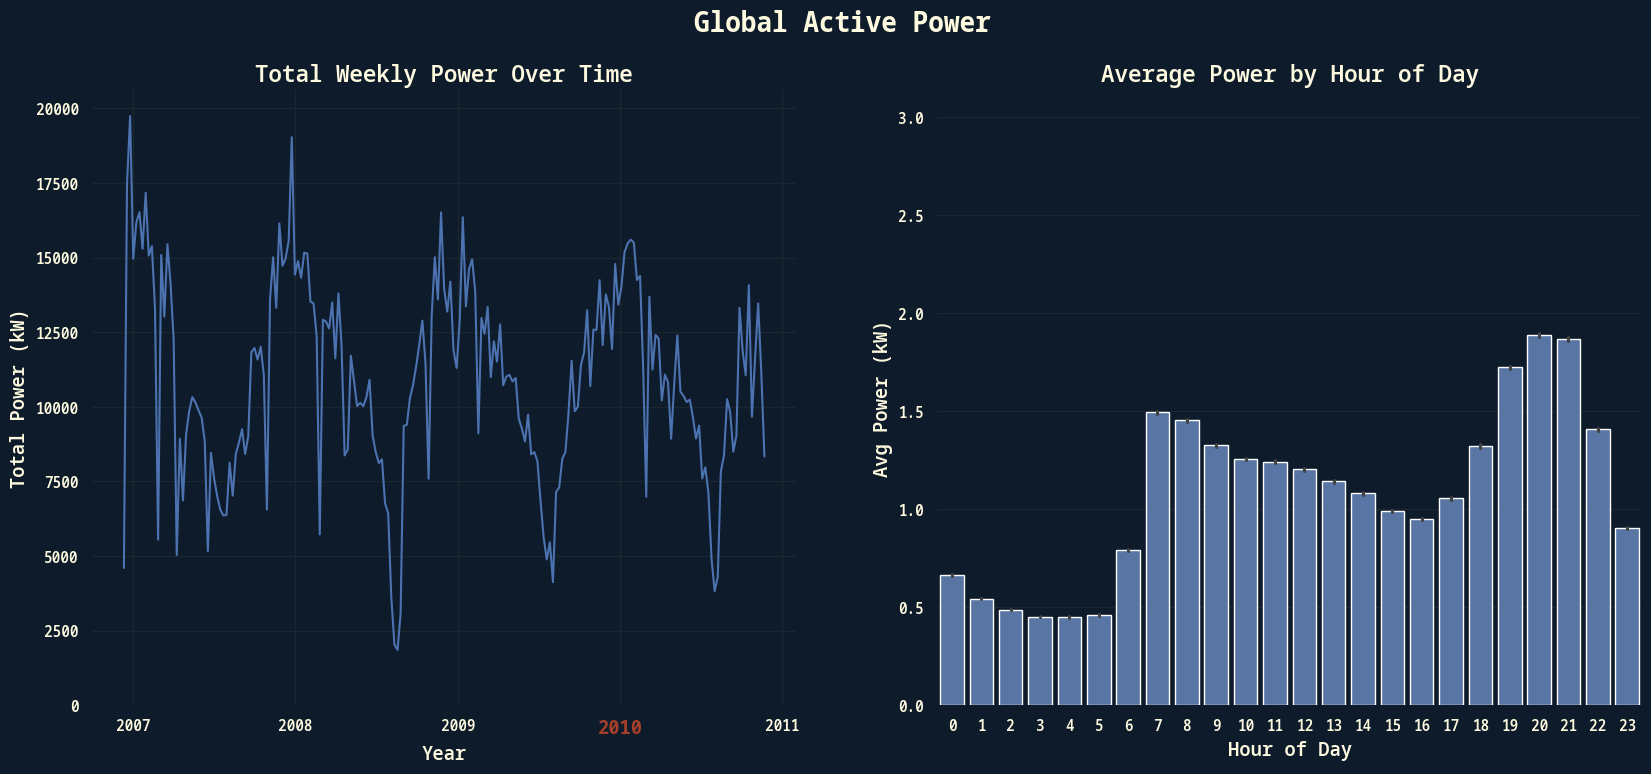

CPU times: user 10.4 s, sys: 1.06 s, total: 11.5 s
Wall time: 10.4 s


In [51]:
%%time
fig, (ax1, ax2) = plt.subplots(
        figsize=(20, 8),
        nrows=1,
        ncols=2,
        dpi=dpi
        )

line_ax = sns.lineplot(
        data=full_line_df,
        x='week_date',
        y='Global_active_power',
        ax=ax1
        )

ax1.xaxis.set_major_locator(mdates.YearLocator())  # Show tick every year
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as '2023'

ax1.set_title('Total Weekly Power Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Power (kW)')

xlim_1 = ax1.get_xlim()

ax1.set_ylim(
        bottom=0,
        top=ax1.get_ylim()[1]
        )

ylim_1 = ax1.get_ylim()

x_ticks_1 = ax1.get_xticks()
y_ticks_1 = ax1.get_yticks()

sns.barplot(
    data=df,
    x='hour_of_day',
    y='Global_active_power',
    ax=ax2,
)

max_year = full_line_df['week_date'].dt.year.max()

# find the x label with the maximum year and color it red
for label in ax1.get_xticklabels():
    if label.get_text() == str(max_year):
        label.set_color(chestnut)
        label.set_fontsize('x-large')
        label.set_weight('bold')

fig.suptitle('Global Active Power', fontsize=20, weight='bold')

ax2.set_title('Average Power by Hour of Day')

# Had to use explicit hour_of_day column, using major locator and formatter was too slow
# ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Show tick every hour
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format as 'HH'

ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Avg Power (kW)')

xlim_2 = ax2.set_xlim(left=-0.5, right=23.5)

ax2.set_ylim(
        bottom=0,
        top=df.groupby(['year', 'hour_of_day'])['Global_active_power'].mean().max() * 1.1
        )

ylim_2 = ax2.get_ylim()

line = line_ax.lines[0]


# Keep the configuration for the frame plots
line_plot_df = pd.DataFrame({
    'x': line.get_xdata(),
    'y': line.get_ydata()
})

xlim = (xlim_1, xlim_2)
ylim = (ylim_1, ylim_2)


plt.show()

## User Configuration

Define the folder name for the frames and the columns to be used for the x and
y axes in the plot.

In [52]:
# Number of frames to generate for the animation
FRAMES = 100

# The folder will be placed under the `frames/` folder
frames_folder_name = "bar_chart"

Define the function to plot a single instance of the visualization

In [53]:
def plot_frame(upper_bound):
    bar_chart_upper_bound = frame_to_upper_bound(
        current_frame=upper_bound,
        nframes_total=nframes_total,
        data_rows=len(df)
    )

    bar_chart_viz_df = df.copy().loc[0:bar_chart_upper_bound, :].reset_index(drop=True)

    line_plot_upper_bound = frame_to_upper_bound(
        current_frame=upper_bound,
        nframes_total=nframes_total,
        data_rows=len(line_plot_df)
    )

    line_plot_viz_df = line_plot_df.loc[0:line_plot_upper_bound, :].reset_index(drop=True)

    fig, (ax1, ax2) = plt.subplots(
            figsize=(20, 8),
            nrows=1,
            ncols=2,
            dpi=dpi
            )

    # First add a line plot with all the data
    sns.lineplot(
            data=line_plot_df,
            x='x',
            y='y',
            ax=ax1,
            color=ash_gray,
            alpha=0.1,
            )

    sns.lineplot(
            data=line_plot_viz_df,
            x='x',
            y='y',
            ax=ax1
            )

    ax1.xaxis.set_major_locator(mdates.YearLocator())  # Show tick every year
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as '2023'

    ax1.set_title('Total Weekly Power Over Time')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Total Power (kW)')

    ax1.set_xlim(xlim[0])
    ax1.set_ylim(ylim[0])

    # Using this in the line plot in fact, but using the bar plot df since that
    # contains the actual date field. The line plot contains the explicit x and
    # y ticks. Had to do it this way to avoid oscilations in the y axis of the
    # line plot.
    max_year = bar_chart_viz_df['datetime'].dt.year.max()

    # find the x label with the maximum year and color it red
    for label in ax1.get_xticklabels():
        if label.get_text() == str(max_year):
            label.set_color(chestnut)
            label.set_fontsize('x-large')
            label.set_weight('bold')

    # Add a vertical line at x = max for lineplot, color chestnut
    ax1.axvline(
        x=line_plot_viz_df['x'].max(),
        color=chestnut,
        linestyle='solid',
        linewidth=1.5,
        label='Current Year'
    )

    sns.barplot(
        data=bar_chart_viz_df,
        x='hour_of_day',
        y='Global_active_power',
        ax=ax2,
    )

    fig.suptitle('Global Active Power', fontsize=20, weight='bold')

    ax2.set_title('Average Power by Hour of Day')

    # Had to use explicit hour_of_day column, using major locator and formatter was too slow
    # ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Show tick every hour
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format as 'HH'

    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Avg Power (kW)')

    ax2.set_xlim(xlim[1])
    ax2.set_ylim(ylim[1])

    return fig, (ax1, ax2)

## Frame Generation

In [54]:
base_frames_folder_path = Path('frames')
frames_folder_path = base_frames_folder_path / Path(frames_folder_name)

animations_folder_path = Path('animations')

print(f"Frames folder path:      {frames_folder_path}")
print(f"Animations folder path:  {animations_folder_path}")

Frames folder path:      frames/bar_chart
Animations folder path:  animations


Prepare the DataFrame for visualization and frame generation.

In [55]:
# Limit to number of frames or less if data is smaller
nframes_total = np.min([
    len(df),
    FRAMES
    ])

Plot the final visualization instance, containing all the data, to check the data and plot style.

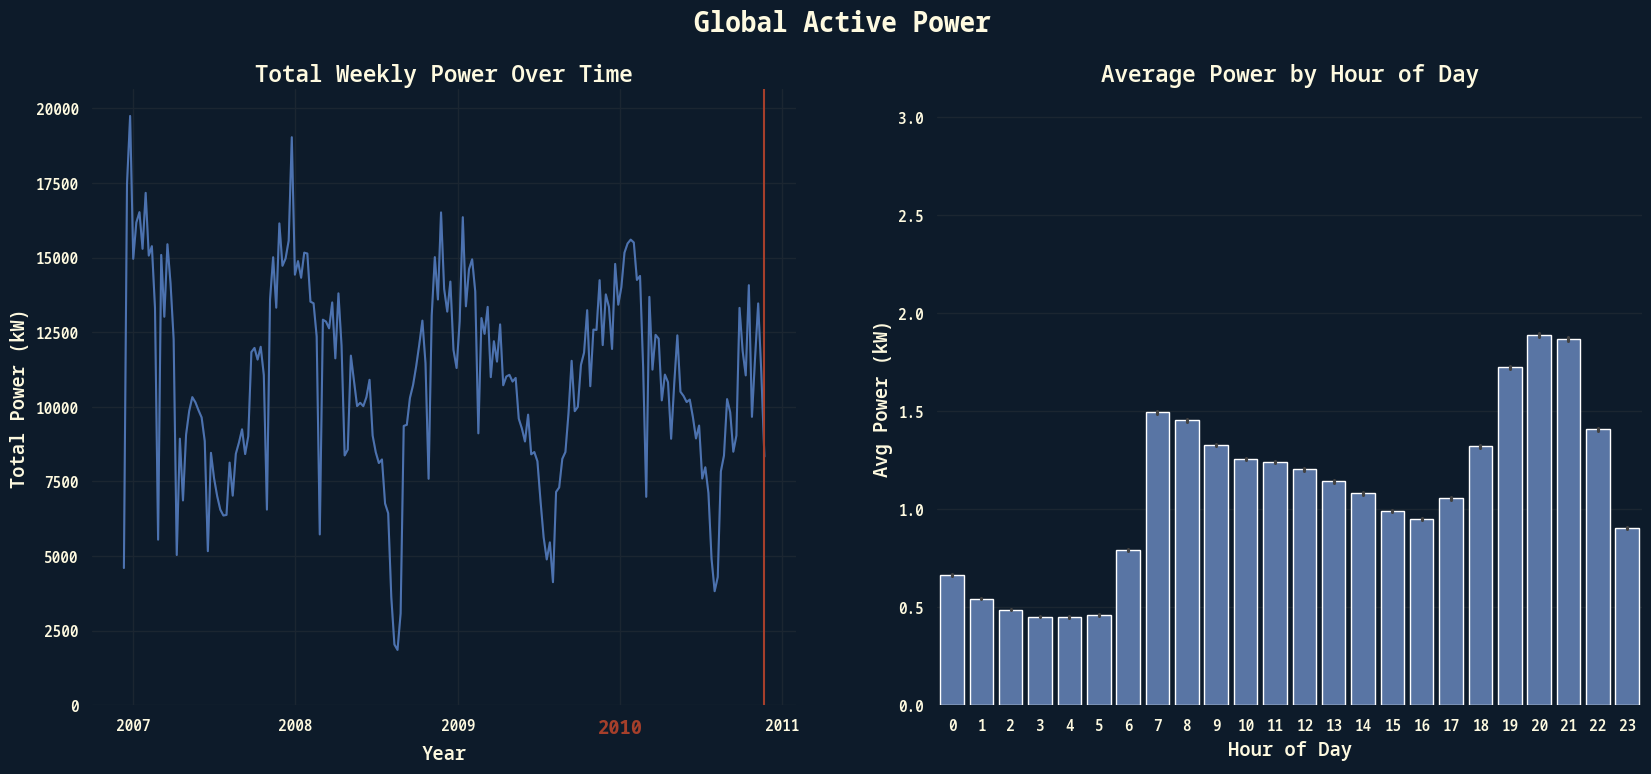

In [56]:
fig, ax = plot_frame(len(df))
plt.show()

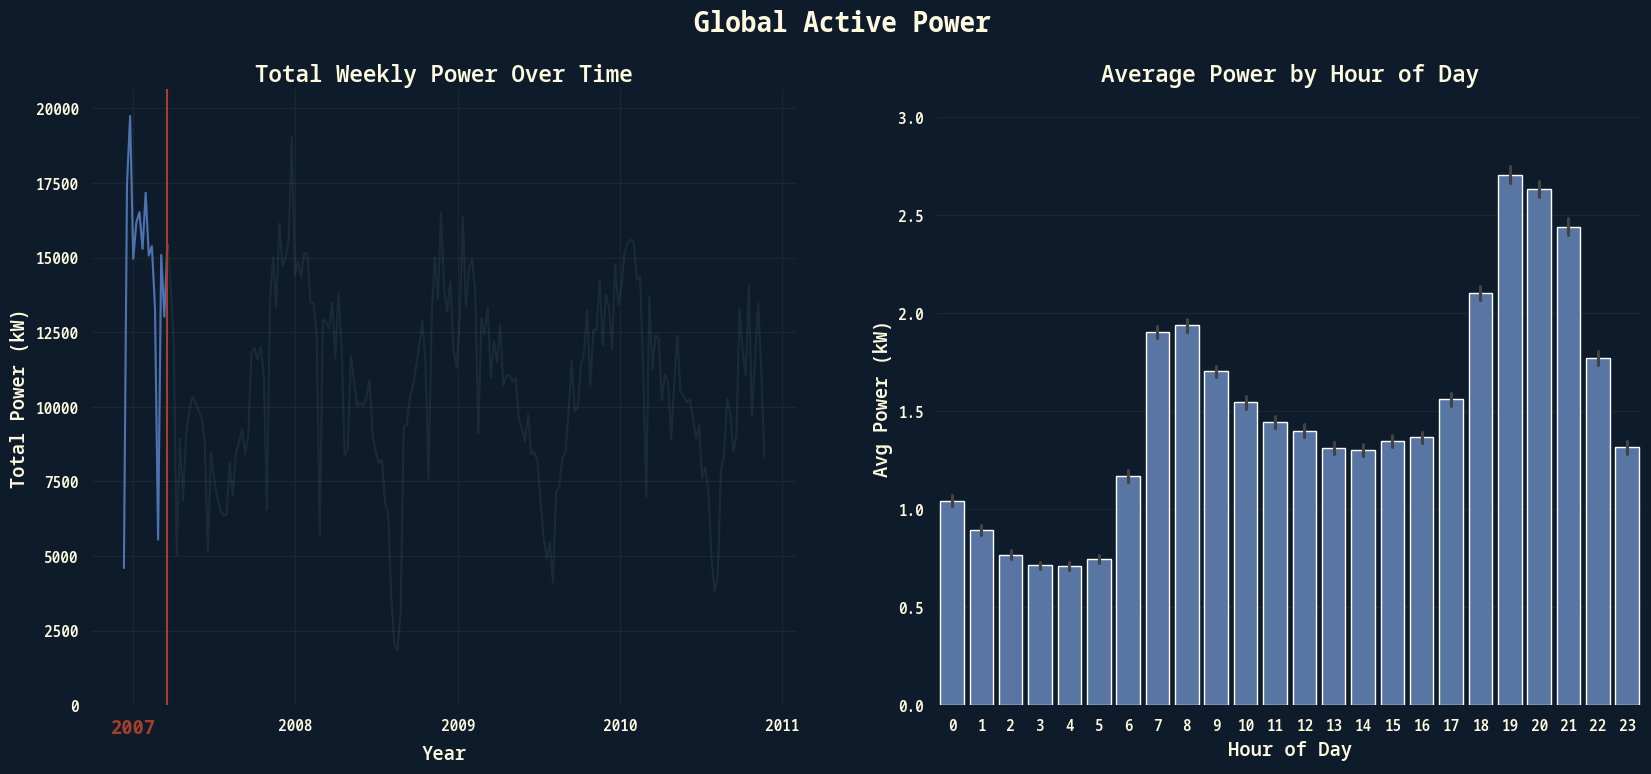

In [57]:
fig, ax = plot_frame(40)
plt.show()

Create the frames for the animation in parallel and store them in the
specified folder.

In [58]:
NPLOTTERS = os.cpu_count()

In [59]:
# Bounds based on the number of frames
bounds = np.linspace(0, nframes_total, NPLOTTERS+1, dtype=int)
bounds

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])

In [60]:
iterable_arguments_for_plotter = [
        (bounds[i], bounds[i+1], frames_folder_path)
        for i in range(NPLOTTERS)
           ]

In [61]:
# Create the frames folder if it does not exist
if not frames_folder_path.exists():
    frames_folder_path.mkdir(parents=True, exist_ok=True)

# Clear frames_folder
for file in frames_folder_path.glob("*.png"):
    file.unlink()

# Create the animations folder if it does not exist
if not animations_folder_path.exists():
    animations_folder_path.mkdir(parents=True, exist_ok=True)

In [62]:
with Pool(processes=NPLOTTERS) as p:
    time.sleep(1)

    timer0 = time.perf_counter()

    p.starmap(create_frames, iterable_arguments_for_plotter, chunksize=1)

    timer1 = time.perf_counter()

    deltat = timer1-timer0

    print(f"\nGenerated {nframes_total} frames in {humanize.naturaldelta(deltat)} ({deltat:.1f} seconds, {nframes_total/deltat:.1f} FPS)")


Generated 600 frames in 23 minutes (1410.6 seconds, 0.4 FPS)


<IPython.core.display.Javascript object>

## Video Generation

Now you can use the generated frames to create an animated GIF or video using
tools like `ffmpeg`.
<br />
<br />
See executable `./gen_animation.sh` for an example of how to generate a video.
The executable takes an argument, the folder name where the frames are
stored, and generates a video named `<folder_name>.mp4`.
<br />
<br />
The following cell runs the shell command to generate the video with the
default gen_animation.sh script.

In [63]:
%%time
# Run the shell command
!./gen_animation.sh {frames_folder_path} && echo "\nVideo generated successfully.\n"

ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

And this one generates a gif:

In [66]:
%%time
# Run the shell command
!./gen_gif.sh {frames_folder_path} && echo "\nGIF generated successfully.\n"

ffmpeg version 5.1.6-0+deb12u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 12 (Debian 12.2.0-14)
  configuration: --prefix=/usr --extra-version=0+deb12u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab --enab

<IPython.core.display.Javascript object>